In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

# Precinct Shapefile

## VEST's Documentation File

Election results from Illinois State Board of Elections(https://www.elections.il.gov/electionoperations/votetotalsearch.aspx)

Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release.

Countywide votes were distributed for Bureau, Kankakee, Livingston, Macon, Perry, Sangamon. It was just 6 votes in Sangamon and 1 to 3 votes in each of the other counties.

The following modifications were made to match precinct boundaries in use for the 2020 general election.

Washington: Merge Hoyleton 1/2
Winnebago: Adjust Rockton 5/11/12/13

- G20PREDBID - Joseph R. Biden (Democratic Party)
- G20PRERTRU - Donald J. Trump (Republican Party)
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20PREGHAW - Howie Hawkins (Green Party)
- G20PREACAR - Brian Carroll (American Solidarity Party)
- G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)


- G20USSDDUR - Richard J. Durbin (Democratic Party)
- G20USSRCUR - Mark C. Curran Jr. (Republican Party)
- G20USSIWIL - Willie L. Wilson (Willie Wilson Party)
- G20USSLMAL - Danny Malouf (Libertarian Party)
- G20USSGBLA - David F. Black (Green Party)


## Load VEST's Final File

In [3]:
vest_shp = gp.read_file("./raw-from-source/VEST/il_2020/il_2020.shp")

In [4]:
vest_shp.shape

(10083, 17)

In [5]:
vest_shp.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PREACAR,G20PRESLAR,G20USSDDUR,G20USSRCUR,G20USSIWIL,G20USSLMAL,G20USSGBLA,geometry
0,17,019,CN0100,17019CN0100,Cunningham 1,753,62,7,9,2,5,684,51,70,12,15,"POLYGON ((-88.23247 40.13302, -88.23175 40.134..."


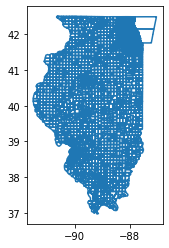

In [6]:
vest_shp.boundary.plot()

# Loading, Combining Election Results

## Load County Fips File

In [10]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Illinois"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Presidential Results

In [8]:
pres_results = pd.read_csv('./raw-from-source/SOS/58-120-PRESIDENT AND VICE PRESIDENT-2020GE.csv')
pres_results.head()

,JurisdictionID,JurisContainerID,JurisName,EISCandidateID,CandidateName,EISContestID,ContestName,PrecinctName,Registration,EISPartyID,PartyName,VoteCount
0,1,0,ADAMS,100,JOSEPH R. BIDEN,120,PRESIDENT AND VICE PRESIDENT,BEVERLY 1,223,11,DEMOCRATIC,21
1,1,0,ADAMS,100,JOSEPH R. BIDEN,120,PRESIDENT AND VICE PRESIDENT,BURTON 1,666,11,DEMOCRATIC,67
2,1,0,ADAMS,100,JOSEPH R. BIDEN,120,PRESIDENT AND VICE PRESIDENT,CAMP POINT 1,520,11,DEMOCRATIC,59
3,1,0,ADAMS,100,JOSEPH R. BIDEN,120,PRESIDENT AND VICE PRESIDENT,CAMP POINT 2,574,11,DEMOCRATIC,49
4,1,0,ADAMS,100,JOSEPH R. BIDEN,120,PRESIDENT AND VICE PRESIDENT,CLAYTON 1,622,11,DEMOCRATIC,91


In [15]:
pres_pivot = pres_results.pivot_table(index = ['JurisdictionID','JurisName','PrecinctName'],
                         columns = ['ContestName','CandidateName'],
                        values = ['VoteCount'],
                         aggfunc = 'sum')
pres_pivot.reset_index(inplace = True)
pres_pivot.head()

JurisdictionID JurisName  PrecinctName  \
ContestName                                            
CandidateName                                          
0                          1     ADAMS     BEVERLY 1   
1                          1     ADAMS      BURTON 1   
2                          1     ADAMS  CAMP POINT 1   
3                          1     ADAMS  CAMP POINT 2   
4                          1     ADAMS     CLAYTON 1   

                                 VoteCount                                 \
ContestName   PRESIDENT AND VICE PRESIDENT                                  
CandidateName                BRIAN CARROLL DONALD J. TRUMP GLORIA LA RIVA   
0                                      0.0           147.0            0.0   
1                                      0.0           494.0            0.0   
2                                      1.0           349.0            0.0   
3                                      0.0           403.0            0.0   
4                                      0.0           383.0            1.0   

                                                                            \
ContestName                                                                  
CandidateName HOWIE HAWKINS JO JORGENSEN JOSEPH R. BIDEN WRITE-IN Write-In   
0                       0.0          0.0            21.0      NaN      NaN   
1                       1.0          8.0            67.0      NaN      NaN   
2                       4.0          8.0            59.0      NaN      NaN   
3                       3.0          3.0            49.0      NaN      NaN   
4                       1.0          2.0            91.0      NaN      NaN   

                        
ContestName             
CandidateName Write-in  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN

In [17]:
pres_pivot.columns = ['JurisdictionID','JurisName','PrecinctName','G20PREACAR','G20PRERTRU','G20PRESLAR','G20PREGHAW','G20PRELJOR','G20PREDBID','wi1','wi2','wi3']
pres_pivot.drop(columns = ['wi1','wi2','wi3'], inplace = True)

In [18]:
pres_pivot.head()

,JurisdictionID,JurisName,PrecinctName,G20PREACAR,G20PRERTRU,G20PRESLAR,G20PREGHAW,G20PRELJOR,G20PREDBID
0,1,ADAMS,BEVERLY 1,0.0,147.0,0.0,0.0,0.0,21.0
1,1,ADAMS,BURTON 1,0.0,494.0,0.0,1.0,8.0,67.0
2,1,ADAMS,CAMP POINT 1,1.0,349.0,0.0,4.0,8.0,59.0
3,1,ADAMS,CAMP POINT 2,0.0,403.0,0.0,3.0,3.0,49.0
4,1,ADAMS,CLAYTON 1,0.0,383.0,1.0,1.0,2.0,91.0


## U.S. Senate Results

In [19]:
uss_results = pd.read_csv('./raw-from-source/SOS/58-160-UNITED STATES SENATOR-2020GE.csv')
uss_results.head()

,JurisdictionID,JurisContainerID,JurisName,EISCandidateID,CandidateName,EISContestID,ContestName,PrecinctName,Registration,EISPartyID,PartyName,VoteCount
0,1,0,ADAMS,140,RICHARD J. DURBIN,160,UNITED STATES SENATOR,BEVERLY 1,223,11,DEMOCRATIC,21
1,1,0,ADAMS,140,RICHARD J. DURBIN,160,UNITED STATES SENATOR,BURTON 1,666,11,DEMOCRATIC,80
2,1,0,ADAMS,140,RICHARD J. DURBIN,160,UNITED STATES SENATOR,CAMP POINT 1,520,11,DEMOCRATIC,65
3,1,0,ADAMS,140,RICHARD J. DURBIN,160,UNITED STATES SENATOR,CAMP POINT 2,574,11,DEMOCRATIC,56
4,1,0,ADAMS,140,RICHARD J. DURBIN,160,UNITED STATES SENATOR,CLAYTON 1,622,11,DEMOCRATIC,98


In [20]:
uss_pivot = uss_results.pivot_table(index = ['JurisdictionID','JurisName','PrecinctName'],
                         columns = ['ContestName','CandidateName'],
                        values = ['VoteCount'],
                         aggfunc = 'sum')
uss_pivot.reset_index(inplace = True)
uss_pivot.head()

JurisdictionID JurisName  PrecinctName             VoteCount  \
ContestName                                          UNITED STATES SENATOR   
CandidateName                                                 DANNY MALOUF   
0                          1     ADAMS     BEVERLY 1                   2.0   
1                          1     ADAMS      BURTON 1                   5.0   
2                          1     ADAMS  CAMP POINT 1                   7.0   
3                          1     ADAMS  CAMP POINT 2                   4.0   
4                          1     ADAMS     CLAYTON 1                   6.0   

                                                                   \
ContestName                                                         
CandidateName DAVID F. BLACK MARK C. CURRAN JR. RICHARD J. DURBIN   
0                        1.0              144.0              21.0   
1                        0.0              477.0              80.0   
2                        0.0              344.0              65.0   
3                        3.0              395.0              56.0   
4                        2.0              361.0              98.0   

                                                           
ContestName                                                
CandidateName WILLIE L. WILSON WRITE-IN Write-In Write-in  
0                          0.0      NaN      NaN      NaN  
1                          2.0      NaN      NaN      NaN  
2                          5.0      NaN      NaN      NaN  
3                          0.0      NaN      NaN      NaN  
4                          5.0      NaN      NaN      NaN

In [21]:
uss_pivot.columns = ['JurisdictionID','JurisName','PrecinctName','G20USSLMAL','G20USSGBLA','G20USSRCUR','G20USSDDUR','G20USSIWIL','wi1','wi2','wi3']
uss_pivot.drop(columns = ['wi1','wi2','wi3'], inplace = True)

In [22]:
uss_pivot.head()

,JurisdictionID,JurisName,PrecinctName,G20USSLMAL,G20USSGBLA,G20USSRCUR,G20USSDDUR,G20USSIWIL
0,1,ADAMS,BEVERLY 1,2.0,1.0,144.0,21.0,0.0
1,1,ADAMS,BURTON 1,5.0,0.0,477.0,80.0,2.0
2,1,ADAMS,CAMP POINT 1,7.0,0.0,344.0,65.0,5.0
3,1,ADAMS,CAMP POINT 2,4.0,3.0,395.0,56.0,0.0
4,1,ADAMS,CLAYTON 1,6.0,2.0,361.0,98.0,5.0


## Combine Results

In [23]:
print(pres_pivot.shape, uss_pivot.shape)

(10113, 9) (10081, 8)


In [25]:
election_results = pres_pivot.merge(uss_pivot, how = 'outer', on = ['JurisName','PrecinctName'], indicator = True)

In [29]:
election_results.groupby('_merge').count()

,JurisdictionID_x,JurisName,PrecinctName,G20PREACAR,G20PRERTRU,G20PRESLAR,G20PREGHAW,G20PRELJOR,G20PREDBID,JurisdictionID_y,G20USSLMAL,G20USSGBLA,G20USSRCUR,G20USSDDUR,G20USSIWIL
_merge,,,,,,,,,,,,,,,
left_only,32,32,32,31,32,31,31,31,31,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
both,10081,10081,10081,8250,10080,8574,9797,9578,10081,10081,9892,10006,10075,10081,10078


In [34]:
election_results.columns

Index(['JurisdictionID_x', 'JurisName', 'PrecinctName', 'G20PREACAR',
       'G20PRERTRU', 'G20PRESLAR', 'G20PREGHAW', 'G20PRELJOR', 'G20PREDBID',
       'JurisdictionID_y', 'G20USSLMAL', 'G20USSGBLA', 'G20USSRCUR',
       'G20USSDDUR', 'G20USSIWIL', '_merge'],
      dtype='object')

In [37]:
election_results[(election_results['_merge'] != 'both')].groupby('JurisName').sum()

,JurisdictionID_x,G20PREACAR,G20PRERTRU,G20PRESLAR,G20PREGHAW,G20PRELJOR,G20PREDBID,JurisdictionID_y,G20USSLMAL,G20USSGBLA,G20USSRCUR,G20USSDDUR,G20USSIWIL
JurisName,,,,,,,,,,,,,
BOND,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BOONE,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BUREAU,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CARROLL,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHRISTIAN,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CLARK,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COLES,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DOUGLAS,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DeWITT,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
election_results[(election_results['_merge'] != 'both') & ((election_results.G20PRERTRU > 0) | (election_results.G20PREDBID > 0))].groupby('JurisName').sum()

,JurisdictionID_x,G20PREACAR,G20PRERTRU,G20PRESLAR,G20PREGHAW,G20PRELJOR,G20PREDBID,JurisdictionID_y,G20USSLMAL,G20USSGBLA,G20USSRCUR,G20USSDDUR,G20USSIWIL
JurisName,,,,,,,,,,,,,
BUREAU,6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KANKAKEE,46,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
LIVINGSTON,53,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MACON,55,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PERRY,73,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SANGAMON,83,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The precincts that did not merge are the 6 ones with county-wide votes that VEST distributed. Max county-wide votes is 6. 

In [66]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(election_results[['JurisName','COUNTYFP']].drop_duplicates())

                    JurisName COUNTYFP
0                       ADAMS      001
74                  ALEXANDER      003
85                       BOND      005
111                     BOONE      007
150                     BROWN      009
164                    BUREAU      011
215                   CALHOUN      013
222                   CARROLL      015
245                      CASS      017
266                 CHAMPAIGN      019
384                 CHRISTIAN      021
415                     CLARK      023
439                      CLAY      025
457                   CLINTON      027
496                     COLES      029
541                      COOK      031
2140                 CRAWFORD      033
2164               CUMBERLAND      035
2176                   DeKALB      037
2241                   DeWITT      039
2265                  DOUGLAS      041
2283                   DuPAGE      043
3214                    EDGAR      045
3246                  EDWARDS      047
3258                EFFIN

Going to only validate the election result totals for now, and not deal with assigning counties to cities that split counties and distributing county wide votes. 

# Validating Election Results

In [67]:
election_results.columns

Index(['JurisdictionID_x', 'JurisName', 'PrecinctName', 'G20PREACAR',
       'G20PRERTRU', 'G20PRESLAR', 'G20PREGHAW', 'G20PRELJOR', 'G20PREDBID',
       'JurisdictionID_y', 'G20USSLMAL', 'G20USSGBLA', 'G20USSRCUR',
       'G20USSDDUR', 'G20USSIWIL', '_merge', 'COUNTYFP', 'CountyName'],
      dtype='object')

In [86]:
data_columns = ['G20PREACAR','G20PRERTRU', 'G20PRESLAR', 'G20PREGHAW', 'G20PRELJOR', 'G20PREDBID', 
                'G20USSLMAL', 'G20USSGBLA', 'G20USSRCUR', 'G20USSDDUR']

print("Printing differences below")
for race in data_columns:
    if (sum(vest_shp[race])- election_results[race].sum() != 0):
        print(race+" has a difference of "+str(sum(vest_shp[race])-election_results[race].sum())+" votes")
        print("\tVEST: "+str(sum(vest_shp[race]))+" votes")
        print("\tSOURCES: "+str(election_results[race].sum())+" votes")
    else:
        print(race + " is equal", "\tVEST: " + str(sum(vest_shp[race])), "\tRDH: " + str(election_results[race].sum()))
print("")
print("All other races are equal")


Printing differences below
G20PREACAR is equal 	VEST: 9548 	RDH: 9548.0
G20PRERTRU is equal 	VEST: 2446891 	RDH: 2446891.0
G20PRESLAR is equal 	VEST: 8046 	RDH: 8046.0
G20PREGHAW is equal 	VEST: 30494 	RDH: 30494.0
G20PRELJOR is equal 	VEST: 66544 	RDH: 66544.0
G20PREDBID is equal 	VEST: 3471915 	RDH: 3471915.0
G20USSLMAL is equal 	VEST: 75673 	RDH: 75673.0
G20USSGBLA is equal 	VEST: 56711 	RDH: 56711.0
G20USSRCUR is equal 	VEST: 2319870 	RDH: 2319870.0
G20USSDDUR is equal 	VEST: 3278930 	RDH: 3278930.0

All other races are equal
